# Simple Load and Store with Aerospike Data on Spark
This notebook shows how to load data from and store processed data to Aerospike Database on Spark. The data transfer is enabled by the Aerospike Connector for Spark.

## Setup
Execute the code cells in this section to set up Aerospike Server, Spark Server, and Spark Connector.

### Ensure Database Is Running
This notebook requires that Aerospike Database is running.

In [1]:
!asd >& /dev/null
!pgrep -x asd >/dev/null && echo "Aerospike database is running!" || echo "**Aerospike database is not running!**"

Aerospike database is running!


### Initialize Spark
We will be using Spark functionality in this notebook.

#### Initialize Paths and Env Variables

In [2]:
# directory where spark notebook requisites are installed
SPARK_NB_DIR = '/opt/spark-nb'
SPARK_DIR = 'spark-dir-link'
SPARK_HOME = SPARK_NB_DIR + '/' + SPARK_DIR
AEROSPIKE_JAR = 'aerospike-jar-link'
AEROSPIKE_JAR_PATH = SPARK_NB_DIR + '/' + AEROSPIKE_JAR

In [3]:
# IP Address or DNS name for one host in your Aerospike cluster
AS_HOST ="localhost"
# Name of one of your namespaces. Type 'show namespaces' at the aql prompt if you are not sure
AS_NAMESPACE = "test" 
AS_PORT = 3000 # Usually 3000, but change here if not
AS_CONNECTION_STRING = AS_HOST + ":"+ str(AS_PORT)

In [4]:
# Locate the Spark installation using the SPARK_HOME parameter.
import findspark
findspark.init(SPARK_HOME)

In [5]:
# Specify the Aerospike Spark Connector jar in the command used to interact with Aerospike.
import os 
os.environ["PYSPARK_SUBMIT_ARGS"] = '--jars ' + AEROSPIKE_JAR_PATH + ' pyspark-shell'

#### Configure Spark Session
Please visit [Configuring Aerospike Connect for Spark](https://docs.aerospike.com/docs/connect/processing/spark/configuration.html) for more information about the properties used on this page.

In [6]:
# imports
import pyspark
from pyspark.context import SparkContext
from pyspark.sql.context import SQLContext
from pyspark.sql.session import SparkSession
from pyspark.sql.types import StringType, StructField, StructType, ArrayType, IntegerType, MapType, LongType, DoubleType

In [7]:
sc = SparkContext.getOrCreate()
conf=sc._conf.setAll([("aerospike.namespace",AS_NAMESPACE),("aerospike.seedhost",AS_CONNECTION_STRING)])
sc.stop()
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession(sc)
sqlContext = SQLContext(sc)

## Store Data into Aerospike
We will first store simple generated data to Aerospike, and then show how to load data from Aerospike.

### Create Data
We create simple age-salary data with a specified distribution and the following structure.
- id: integer 
- name: string
- age: integer
- salary: integer

In [8]:
# We create age vs salary data, using three different Gaussian distributions
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

# Make sure we get the same results every time this workbook is run
# Otherwise we are occasionally exposed to results not working out as expected
np.random.seed(12345)

# Create covariance matrix from std devs + correlation
def covariance_matrix(std_dev_1,std_dev_2,correlation):
    return [[std_dev_1 ** 2, correlation * std_dev_1 * std_dev_2], 
           [correlation * std_dev_1 * std_dev_2, std_dev_2 ** 2]]

# Return a bivariate sample given means/std dev/correlation
def age_salary_sample(distribution_params,sample_size):
    mean = [distribution_params["age_mean"], distribution_params["salary_mean"]]
    cov = covariance_matrix(distribution_params["age_std_dev"],distribution_params["salary_std_dev"],
                            distribution_params["age_salary_correlation"])
    return np.random.multivariate_normal(mean, cov, sample_size).T

# Define the characteristics of our age/salary distribution
age_salary_distribution_1 = {"age_mean":25,"salary_mean":50000,
                             "age_std_dev":1,"salary_std_dev":5000,"age_salary_correlation":0.3}

age_salary_distribution_2 = {"age_mean":45,"salary_mean":80000,
                             "age_std_dev":4,"salary_std_dev":8000,"age_salary_correlation":0.7}

age_salary_distribution_3 = {"age_mean":35,"salary_mean":70000,
                             "age_std_dev":2,"salary_std_dev":9000,"age_salary_correlation":0.1}

distribution_data = [age_salary_distribution_1,age_salary_distribution_2,age_salary_distribution_3]

# Sample age/salary data for each distributions
sample_size_1 = 100;
sample_size_2 = 120;
sample_size_3 = 80;
sample_sizes = [sample_size_1,sample_size_2,sample_size_3]
group_1_ages,group_1_salaries = age_salary_sample(age_salary_distribution_1,sample_size=sample_size_1)
group_2_ages,group_2_salaries = age_salary_sample(age_salary_distribution_2,sample_size=sample_size_2)
group_3_ages,group_3_salaries = age_salary_sample(age_salary_distribution_3,sample_size=sample_size_3)

ages=np.concatenate([group_1_ages,group_2_ages,group_3_ages])
salaries=np.concatenate([group_1_salaries,group_2_salaries,group_3_salaries])

print("Data created")

Data created


### Display Data

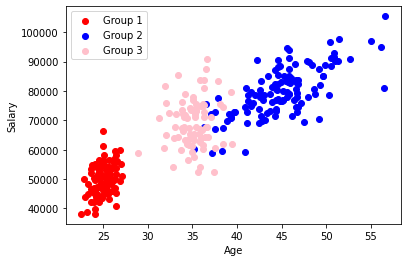

In [9]:
# Plot the sample data
group_1_colour, group_2_colour, group_3_colour ='red','blue', 'pink'
plt.xlabel('Age',fontsize=10)
plt.ylabel("Salary",fontsize=10) 

plt.scatter(group_1_ages,group_1_salaries,c=group_1_colour,label="Group 1")
plt.scatter(group_2_ages,group_2_salaries,c=group_2_colour,label="Group 2")
plt.scatter(group_3_ages,group_3_salaries,c=group_3_colour,label="Group 3")

plt.legend(loc='upper left')
plt.show()

### Save Data
We save the generated data in the set "salary_data" defined in `aerospike.set` parameter below and in the namespace "test" that was specified in the Spark context above as `aerospike.namespace`.

In [10]:
# Turn the above records into a Data Frame
# First of all, create an array of arrays
inputBuf = []

for  i in range(0, len(ages)) :
     id = i + 1 # Avoid counting from zero
     name = "Individual: {:03d}".format(id)
     # Note we need to make sure values are typed correctly
     # salary will have type numpy.float64 - if it is not cast as below, an error will be thrown
     age = float(ages[i])
     salary = int(salaries[i])
     inputBuf.append((id, name,age,salary))

# Convert to an RDD 
inputRDD = spark.sparkContext.parallelize(inputBuf)
       
# Convert to a data frame using a schema
schema = StructType([
    StructField("id", IntegerType(), True),
    StructField("name", StringType(), True),
    StructField("age", DoubleType(), True),
    StructField("salary",IntegerType(), True)
])

inputDF=spark.createDataFrame(inputRDD,schema)

#Write the data frame to Aerospike, the id field is used as the primary key
inputDF \
.write \
.mode('overwrite') \
.format("aerospike")  \
.option("aerospike.set", "salary_data")\
.option("aerospike.updateByKey", "id") \
.save()

### View Stored Data
Use the Aerospike AQL utility to view the stored data.

In [11]:
!aql -c "select * from test.salary_data"

select * from test.salary_data
+-------------------+-----+-------------------+--------+
| age               | id  | name              | salary |
+-------------------+-----+-------------------+--------+
| 25.08233874902072 | 10  | "Individual: 010" | 58345  |
| 54.98712625322746 | 160 | "Individual: 160" | 97029  |
| 45.18908097916793 | 120 | "Individual: 120" | 80007  |
| 22.79485298523146 | 34  | "Individual: 034" | 49882  |
| 31.29085325544791 | 243 | "Individual: 243" | 70754  |
| 44.89546664470054 | 159 | "Individual: 159" | 82870  |
| 24.94527795295446 | 13  | "Individual: 013" | 47114  |
| 42.71790399344467 | 128 | "Individual: 128" | 83366  |
| 25.27733154496998 | 56  | "Individual: 056" | 47356  |
| 26.87692699227393 | 47  | "Individual: 047" | 49425  |
| 22.91486461859545 | 66  | "Individual: 066" | 43879  |
| 23.62771625204453 | 60  | "Individual: 060" | 53345  |
| 33.77525922313378 | 271 | "Individual: 271" | 59730  |
| 25.65434773386738 | 32  | "Individual: 032" | 50250  |


## Load Data from Aerospike
We will show multiple ways of loading data into a data frame.

### Load data without schema 
The Aerospike Spark Connector can infer the schema by reading a number of records. This method returns data as well as metadata fields such as \_\_key, \_\_digest, \_\_expiry, \_\_generation, and \_\_ttl.

In [12]:
# Create a Spark DataFrame by using the Connector Schema inference mechanism
# The fields preceded with __ are metadata fields - key/digest/expiry/generation/ttl
# By default you just get everything, with no column ordering, which is why it looks untidy
# Note we don't get anything in the 'key' field as we have not chosen to save as a bin.
# Use .option("aerospike.sendKey", True) to do this

loadedDFWithoutSchema = (
    spark.read.format("aerospike") \
    .option("aerospike.set", "salary_data") \
    .load()
)

loadedDFWithoutSchema.show(10)

+-----+--------------------+---------+------------+-------+------------------+---------------+------+---+
|__key|            __digest| __expiry|__generation|  __ttl|               age|           name|salary| id|
+-----+--------------------+---------+------------+-------+------------------+---------------+------+---+
| null|[03 50 2E 7F 70 9...|401502284|           4|2591999|34.652141285212814|Individual: 239| 61747|239|
| null|[0F 10 1A 93 B1 E...|401502284|           4|2591999| 45.57430980213641|Individual: 194| 94548|194|
| null|[04 C0 5E 9A 68 5...|401502284|           4|2591999| 46.53337694047583|Individual: 101| 89019|101|
| null|[1A E0 A8 A0 F2 3...|401502284|           4|2591999| 25.24920420954561|Individual: 031| 54312| 31|
| null|[23 20 78 35 5D 7...|401502284|           4|2591999| 38.84745269824979|Individual: 139| 69645|139|
| null|[35 00 8C 78 43 F...|401502284|           4|2591999| 25.59043077849547|Individual: 014| 51513| 14|
| null|[37 00 6D 21 08 9...|401502284|        

### Load data using schema 
The schema can be explicitly specified, and only these fields will be returned. Note the `schema` used here was constructed earlier with id, name, age, and salary fields.

In [13]:
# If we explicitly set the schema, using the previously created schema object
# we effectively type the rows in the Data Frame

loadedDFWithSchema=spark \
.read \
.format("aerospike") \
.schema(schema) \
.option("aerospike.set", "salary_data").load()

loadedDFWithSchema.show(5)

+---+---------------+------------------+------+
| id|           name|               age|salary|
+---+---------------+------------------+------+
|101|Individual: 101| 46.53337694047583| 89019|
|239|Individual: 239|34.652141285212814| 61747|
|194|Individual: 194| 45.57430980213641| 94548|
| 31|Individual: 031| 25.24920420954561| 54312|
|139|Individual: 139| 38.84745269824979| 69645|
+---+---------------+------------------+------+
only showing top 5 rows



### Pushing Down Query Predicate
In order to get the best performance, it is important to minimize the amount of data retrieved to Spark. This is achieved by "pushing down" the query predicate or by processing filters in the database.

The Spark Connector allows the "pushdown expressions" option for specifying filters to be processed on Aerospike. Note that it cannot be used in `load` together with the `where` clause.

Below, we have used the Base64 encoding of a simple expression `id % 5 = 0` to get records where the id field is divisble by 5. Please see the notebook [Pushdown Expressions for Spark Connector](https://github.com/aerospike-examples/interactive-notebooks/blob/main/notebooks/spark/resources/pushdown-expressions.ipynb) for details on constructing an expresion and obtaining its Base64 repreentation.

**Compute Base64 Representation of Predicate**

In [14]:
import aerospike
from aerospike_helpers import expressions as exp

# Configure the client connection
config = {
    'hosts': [ ('127.0.0.1', 3000) ]
}
# Connect to the server
try:
    client = aerospike.client(config).connect()
except ex.ClientError as e:
    print("Error: {0} [{1}]".format(e.msg, e.code))
    sys.exit(1)

# Build the expression for id % 5 = 0
expr = exp.Eq(
            exp.IntBin("id") % 5, 
            0).compile()
# Get Base64 representation of the expression for use in a pushdown-expression request.
pushdown_expr = client.get_expression_base64(expr)
client.close()
print('The base64 representation of the expression "id % 5 = 0" is', pushdown_expr)

Base64 representation of the expression "id % 5 = 0" is kwGTGpNRAqJpZAUA


**Load Using Pushdown Expressions**

In [15]:
dfWithPushdownExpr = spark \
    .read \
    .format("aerospike") \
    .schema(schema) \
    .option("aerospike.set", "salary_data") \
    . option("aerospike.pushdown.expressions", pushdown_expr) \
    .load()

dfWithPushdownExpr.show(10)

+---+---------------+------------------+------+
| id|           name|               age|salary|
+---+---------------+------------------+------+
| 10|Individual: 010|25.082338749020725| 58345|
|140|Individual: 140| 43.06512046705784| 78500|
|160|Individual: 160| 54.98712625322746| 97029|
|120|Individual: 120|45.189080979167926| 80007|
|205|Individual: 205| 41.55122933798243| 74759|
|195|Individual: 195| 44.41128454132044| 73805|
|145|Individual: 145|43.667753041813405| 73062|
|300|Individual: 300|34.047281047784914| 67622|
|105|Individual: 105|  42.5158131767696| 73984|
|170|Individual: 170| 49.63878026576844| 84917|
+---+---------------+------------------+------+
only showing top 10 rows



### Using Secondary Index
First we create a secondary index on the salary field, and then retrieve data using the secondary index.

In [16]:
# create a secondary index on salary
import aerospike 
from aerospike import exception as ex

client = aerospike.client({"hosts": [AS_HOST]}).connect()
# create a secondary index on salary
index_name = "idx_salary_int"
try:
    client.index_integer_create('test', 'salary_data', "salary", index_name)
except ex.IndexFoundError as e:
    pass

In [17]:
# automatically selects appropriate secindary index
dfWithSecIdx = spark \
    .read \
    .format("aerospike") \
    .schema(schema) \
    .option("aerospike.set", "salary_data") \
    .option("aerospike.sindex.enable", "true") \
    .load() \
    .where("salary >= 100000")

dfWithSecIdx.show()

+---+---------------+----------------+------+
| id|           name|             age|salary|
+---+---------------+----------------+------+
|206|Individual: 206|56.6362187203851|105414|
+---+---------------+----------------+------+



## Next Steps
To learn more about the Spark Connector, check out the [multiple tutorials](https://developer.aerospike.com/tutorials/spark). [Aerospike Connect for Spark Tutorial for Python](https://developer.aerospike.com/tutorials/spark/spark-py) is a good reference for the connector capabilities.